In [61]:
from utils import *
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
'''
Read the data and split it into train and test sets
'''
data = pd.read_csv('Data/data_with_lags_and_sentiment_feature_selected.csv', index_col=0, parse_dates=True)

test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

In [77]:
data.columns

Index(['Realized Volatility', 'Realized Volatility_lag_1',
       'Realized Volatility_lag_2', 'US EPU Index_lag_1', 'VIX Index_lag_1',
       'Volume_lag_2', 'Term Spread_ret_lag_2', '13w TB_ret_lag_1',
       '13w TB_ret_lag_2', 'Abs Return_lag_1', 'Sentiment Score_lag_1'],
      dtype='object')

In [63]:
'''
Class for RNN model
'''
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation, dropout):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity=activation)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

'''
Class for LSTM model
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob, activation):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = getattr(nn, activation)() if activation != 'relu' else nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out
'''
Function for training a PyTorch model
'''
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

In [64]:
def evaluate_deep_models_ts_cv(train_data, test_data, param_grid, n_splits=5, model_name=None, plot_shap = True, directory = ''):
    '''
    
    :param train_data: Training data
    :param test_data: Test data
    :param param_grid: Hyperparameters grid to search
    :param n_splits: Number of slits for Cross validation
    :param model_name: Name of the model can be 'XGBoost', 'Random Forest', 'RNN', 'LSTM'
    :param plot_shap: Whether to plot SHAP values or not
    :param directory: Where to save the plots
    :return: The best model and the predictions on the test set
    '''
    # Extract target and features
    y_train = train_data.iloc[:, 0]
    X_train = train_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    X_test = test_data.iloc[:, 1:]

    best_score = np.inf
    best_params = None

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['Realized Volatility'])

    tscv = TimeSeriesSplit(n_splits=n_splits)

    param_combinations = list(ParameterGrid(param_grid))

    for params in param_combinations:
        cv_scores = []
        for train_index, val_index in tscv.split(X_scaled):
            X_tr, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
            y_tr, y_val = y_scaled.iloc[train_index], y_scaled.iloc[val_index]
            
            if model_name == 'XGBoost':
                model = xgb.XGBRegressor(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
            elif model_name == 'Random Forest':
                model = RandomForestRegressor(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
            elif model_name == 'RNN':
                # Convert to PyTorch tensors and create DataLoader
                X_tr_tensor = torch.tensor(X_tr.values, dtype=torch.float32).unsqueeze(1)
                y_tr_tensor = torch.tensor(y_tr.values, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)
                y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
                train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
                train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
                                
                input_size = X_tr.shape[1]
                model = RNNModel(input_size, params['unit'], 1, params['activation'], params['dropout'])
                
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'adam' else optim.RMSprop(model.parameters(), lr=params['lr'])
                train_pytorch_model(model, train_loader, criterion, optimizer, params['epochs'])
                
                model.eval()
                with torch.no_grad():
                    y_pred_tensor = model(X_val_tensor)
                    y_pred = y_pred_tensor.numpy()
            elif model_name == 'LSTM':
                # Convert to PyTorch tensors and create DataLoader
                X_tr_tensor = torch.tensor(X_tr.values, dtype=torch.float32).unsqueeze(1)
                y_tr_tensor = torch.tensor(y_tr.values, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)
                y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
                train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
                train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
                input_size = X_tr.shape[1]
                model = LSTMModel(input_size, params['unit'], 1, params['num_layers'], params['dropout'], params['activation'])
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'adam' else optim.RMSprop(model.parameters(), lr=params['lr'])
                train_pytorch_model(model, train_loader, criterion, optimizer, params['epochs'])
                
                model.eval()
                with torch.no_grad():
                    y_pred_tensor = model(X_val_tensor)
                    y_pred = y_pred_tensor.numpy()

            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index=y_val.index)

            MAPE = mean_absolute_percentage_error(scaler_y.inverse_transform(y_val), y_pred)
            cv_scores.append(MAPE)

        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params

        print(f"Results for params = {params}: MAPE = {mean_cv_score}")

    print(f"Best hyperparameters: {best_params} which gives MAPE: {best_score}")

    if model_name == 'XGBoost':
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_scaled, y_scaled)
    elif model_name == 'Random Forest':
        best_model = RandomForestRegressor(**best_params)
        best_model.fit(X_scaled, y_scaled)
    elif model_name == 'RNN':
        input_size = X_train.shape[1]
        best_model = RNNModel(input_size, best_params['unit'], 1, best_params['activation'], best_params['dropout'])
    elif model_name == 'LSTM':
        input_size = X_train.shape[1]
        best_model = LSTMModel(input_size, best_params['unit'], 1, best_params['num_layers'], best_params['dropout'], best_params['activation'])
    
    if model_name in ['RNN', 'LSTM']:
        X_scaled_tensor = torch.tensor(X_scaled.values, dtype=torch.float32).unsqueeze(1)
        y_scaled_tensor = torch.tensor(y_scaled.values, dtype=torch.float32)
        train_dataset = TensorDataset(X_scaled_tensor, y_scaled_tensor)
        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
        criterion = nn.MSELoss()
        optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr']) if best_params['optimizer'] == 'adam' else optim.RMSprop(best_model.parameters(), lr=best_params['lr'])
        train_pytorch_model(best_model, train_loader, criterion, optimizer, best_params['epochs'])

    X_test_scaled = scaler_X.transform(X_test)
    if model_name in ['XGBoost', 'Random Forest']:
        y_test_pred = best_model.predict(X_test_scaled)
    elif model_name in ['RNN', 'LSTM']:
        X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
        best_model.eval()
        with torch.no_grad():
            y_test_pred_tensor = best_model(X_test_scaled_tensor)
            y_test_pred = y_test_pred_tensor.numpy()
    
    y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_pred = pd.DataFrame(y_test_pred, columns=['Realized Volatility'], index=y_test.index)
    
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_test_pred)
    # Assuming calculate_cp, calculate_adjusted_r2, calculate_aic_bic functions are defined
    cp = calculate_cp(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])
    aic, bic = calculate_aic_bic(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])

    print(f"################################\n Test set results: MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}, Adjusted R^2: {adjusted_r2}, C_p: {cp}, AIC: {aic}, BIC: {bic}, MAPE: {MAPE}")

    if model_name in ['LSTM', 'RNN'] and plot_shap:
        explainer = shap.DeepExplainer(best_model, X_scaled_tensor)
        shap_values = explainer.shap_values(X_test_scaled_tensor, check_additivity=False)

        shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[2])

        X_test_scaled_tensor = X_test_scaled_tensor.reshape(X_test_scaled_tensor.shape[0], X_test_scaled_tensor.shape[2])
        X_test_scaled_tensor = np.array(X_test_scaled_tensor)

        plt.figure()  # Ensure a new figure is created
        shap.summary_plot(shap_values, X_test_scaled_tensor, feature_names=X_test.columns, show=False)
        plt.savefig(f'Outputs/Models/{directory}/SHAP_dot_summary_plot.png')
        plt.close()  # Close the figure to free memory
    
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_scaled_tensor, feature_names=X_test.columns, plot_type='bar', show=False)
        plt.title('SHAP Summary Plot (Bar)')
        plt.savefig(f'Outputs/Models/{directory}/SHAP_bar_summary_plot.png')
        plt.close()  # Close the figure to free memory

    return best_model, y_test_pred


In [65]:
'''
Function for setting the seed to make the results reproducible
'''
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

1 - LSTM model with multiple inputs

In [66]:
set_seed()

lstm_hyperparameters = {
    'unit': [50, 20],
    'num_layers': [1],
    'activation': ['relu'],
    'dropout': [0.1, 0.2],
    'optimizer': ['adam'],
    'epochs': [100, 200],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}


best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, lstm_hyperparameters, model_name='LSTM', n_splits=5, directory='LSTM_multiple_input')

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.34821154345981525


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.34056391541736175


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.31405928713420267


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3131834084302845


100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.30931133903496577


100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3428356569705313


100%|██████████| 200/200 [00:47<00:00,  4.20it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3178916236976924


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.31348986837552106


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3057678931475455


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.2841685047710115


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3132732709877076


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.32725921176367834


100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.30245467715215757


100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.2817587758601957


100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.32616916570832954


100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3122963845982252
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20} which gives MAPE: 0.2817587758601957


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


################################
 Test set results: MSE: 4.220098760750918e-06, RMSE: 0.002054287896267443, MAE: 0.0015813664109414413, R^2: 0.12654036874567953, Adjusted R^2: 0.12130380021297982, C_p: 0.00013256535730557894, AIC: -inf, BIC: -14936.594600590995, MAPE: 0.29365318319489836


In [69]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_LSTM = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_LSTM.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.008002
2023-04-06,0.005496,0.008297
2023-04-10,0.008563,0.007722
2023-04-11,0.003862,0.008541
2023-04-12,0.009014,0.007560


In [70]:
results_LSTM.to_csv('Outputs/Models/LSTM_multiple_input/LSTM_results.csv')

<Axes: >

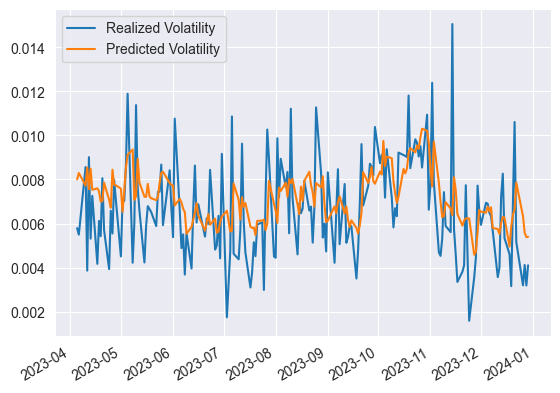

In [71]:
results_LSTM.plot()

2 - XGBoost model

In [28]:
set_seed()

xgboost_param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 10],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5]
}

best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, xgboost_param_grid, model_name='XGBoost')


Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}: MAPE = 0.3442320536277893
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}: MAPE = 0.35937998249353015
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}: MAPE = 0.3458849644889961
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500}: MAPE = 0.3612109887616392
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}: MAPE = 0.36185974600841636
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500}: MAPE = 0.36185974600841636
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 100}: MAPE = 0.34691496459309523
Results for params = {'colsample_bytree': 0.7, 'max_dep

In [29]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_XGBoost = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_XGBoost.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006711
2023-04-06,0.005496,0.006148
2023-04-10,0.008563,0.006237
2023-04-11,0.003862,0.007337
2023-04-12,0.009014,0.006622


In [30]:
results_XGBoost.to_csv('Outputs/Models/XGBoost/XGBoost_results.csv')

<Axes: >

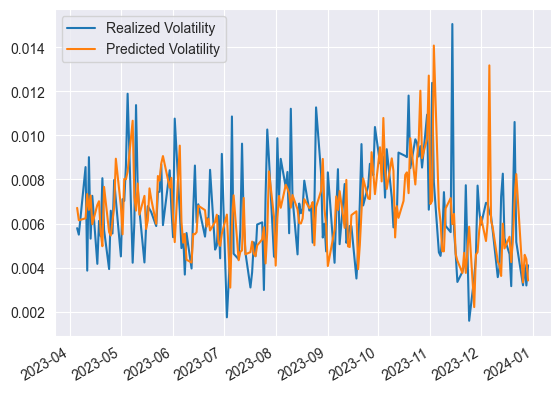

In [31]:
results_XGBoost.plot()

3 - Random Forest model

In [32]:
set_seed()
# Random Forest
random_forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt']
}
best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, random_forest_param_grid, model_name='Random Forest')

Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}: MAPE = 0.3166473318701598
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}: MAPE = 0.32263364455248017
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}: MAPE = 0.3271508985571794
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}: MAPE = 0.32126615194889185
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}: MAPE = 0.3187804967744619
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}: MAPE = 0.3176086372707185
Results for params = {'max_depth': 10, 'max_featur

In [33]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_RandomForest = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_RandomForest.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.007204
2023-04-06,0.005496,0.007643
2023-04-10,0.008563,0.006179
2023-04-11,0.003862,0.007784
2023-04-12,0.009014,0.006617


In [34]:
results_RandomForest.to_csv('Outputs/Models/Random Forest/RandomForest_results.csv')

<Axes: >

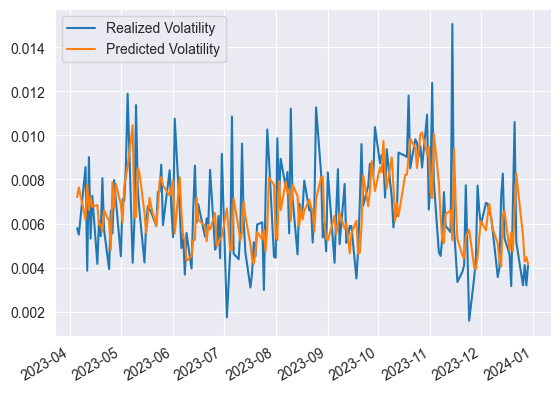

In [35]:
results_RandomForest.plot()

4 - RNN model

In [72]:
set_seed()

rnn_hyperparameters = {
    'unit': [50, 20],
    'activation': ['relu'],
    'dropout': [0.1, 0.2],
    'optimizer': ['adam'],
    'epochs': [100, 200],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}



best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, rnn_hyperparameters, model_name='RNN', directory='RNN')


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.37204664893225997


100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.37849036423038773


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3278669284143205


100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.31265904710097886


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3844534916435247


100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.4149680902555608


100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.35287658260298105


100%|██████████| 200/200 [00:32<00:00,  6.18it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.31269479970484654


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3779963249907153


100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.39781138243208947


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.31410941345465326


100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3148261263466283


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.34835012377689445


100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.46287891132642073


100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.355917858908055


100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.32940331768404
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20} which gives MAPE: 0.31265904710097886


100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


################################
 Test set results: MSE: 4.700658297876911e-06, RMSE: 0.002168100158635876, MAE: 0.0015654626724797703, R^2: 0.027076024451725855, Adjusted R^2: 0.02124314690047724, C_p: 0.00015237490089597632, AIC: -inf, BIC: -14702.763375213412, MAPE: 0.24373684060108186


In [73]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_RNN = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_RNN.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006651
2023-04-06,0.005496,0.006686
2023-04-10,0.008563,0.006469
2023-04-11,0.003862,0.006702
2023-04-12,0.009014,0.006418


In [74]:
results_RNN.to_csv('Outputs/Models/RNN/RNN_results.csv')

<Axes: >

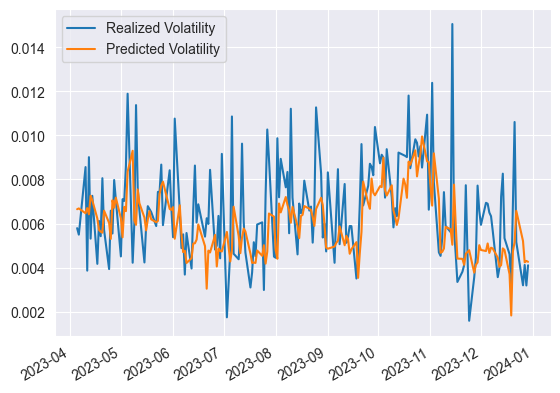

In [75]:
results_RNN.plot()

5 - LSTM model with single input: Absolute returns

In [40]:
data2 = data[['Realized Volatility', 'Abs Return_lag_1']]

In [41]:
test_data2 = data2.iloc[-int(len(data) * 0.1):]
train_data2 = data2.iloc[:-int(len(data) * 0.1)]

In [100]:
lstm_hyperparameters = {
    'unit': [5, 10],
    'num_layers': [1],
    'activation': ['relu'],
    'dropout': [0.1],
    'optimizer': ['adam'],
    'epochs': [50, 100],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}


best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data2, test_data2, lstm_hyperparameters, model_name='LSTM', n_splits=5, plot_shap=False)

100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.5175198570087155


100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.518483045493834


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.550433331069263


100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.4471515087944134


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.5090539600334396


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.5147064392402416


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.48020135876994036


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.4519528869329822
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10} which gives MAPE: 0.4471515087944134


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]

################################
 Test set results: MSE: 1.3160980647936149e-05, RMSE: 0.0036278065891025874, MAE: 0.002949321381635446, R^2: -1.7240085968144614, Adjusted R^2: -1.7256329310999798, C_p: 0.0003074275000093391, AIC: -inf, BIC: -13573.10370222155, MAPE: 0.5618164150467678


In [101]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_LSTM2 = pd.concat([test_data2[['Realized Volatility']], y_test_pred], axis = 1)
results_LSTM2.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.008943
2023-04-06,0.005496,0.007427
2023-04-10,0.008563,0.007907
2023-04-11,0.003862,0.006669
2023-04-12,0.009014,0.006280


In [102]:
results_LSTM2.to_csv('Outputs/Models/LSTM_single_input/LSTM_single_input_results.csv')

<Axes: >

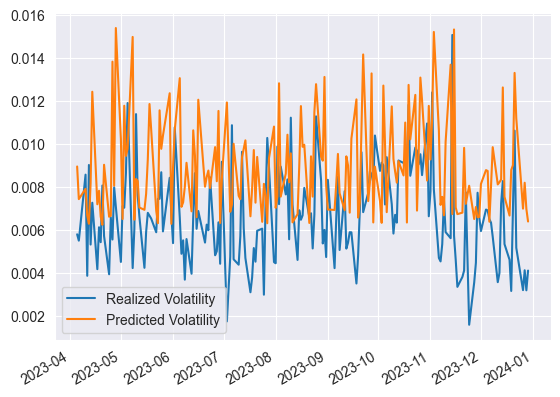

In [103]:
results_LSTM2.plot()

LSTM with single input: Realized Volatility Lag 1

In [47]:
data3 = data[['Realized Volatility', 'Realized Volatility_lag_1']]

In [48]:
test_data3 = data3.iloc[-int(len(data) * 0.1):]
train_data3 = data3.iloc[:-int(len(data) * 0.1)]

In [49]:
lstm_hyperparameters = {
    'unit': [5, 10],
    'num_layers': [1],
    'activation': ['relu'],
    'dropout': [0.1],
    'optimizer': ['adam'],
    'epochs': [50, 100],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}


best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data3, test_data3, lstm_hyperparameters, model_name='LSTM', n_splits=5, plot_shap=False)

100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.37801411417904707


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.3259550159621074


100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.47804079581502734


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.4455361618139455


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.3296309983743098


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.3230922251275806


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.4079472287051321


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.3929941945666681
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10} which gives MAPE: 0.3230922251275806


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


################################
 Test set results: MSE: 1.053941837439035e-05, RMSE: 0.003246447038593168, MAE: 0.0026713093862471343, R^2: -1.1814078316242878, Adjusted R^2: -1.1827086114881067, C_p: 0.00024960509389251813, AIC: -inf, BIC: -13922.938870564241, MAPE: 0.526156452581826


In [50]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_LSTM3 = pd.concat([test_data3[['Realized Volatility']], y_test_pred], axis = 1)
results_LSTM3.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.008441
2023-04-06,0.005496,0.008158
2023-04-10,0.008563,0.007952
2023-04-11,0.003862,0.010182
2023-04-12,0.009014,0.006842


In [51]:
results_LSTM3.to_csv('Outputs/Models/LSTM_single_input/LSTM_single_input_RV_results.csv')

<Axes: >

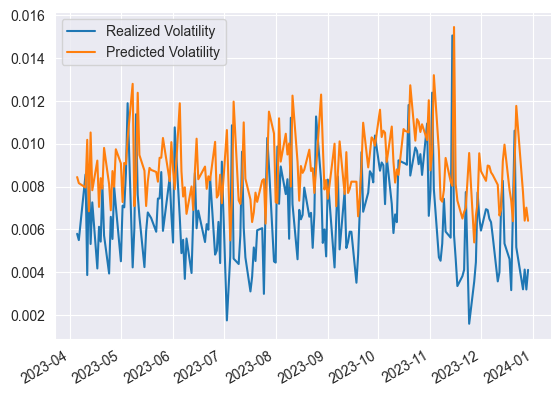

In [52]:
results_LSTM3.plot()